# 5 Neural Network SMS Text Classifier

## 5.1 Problem Description

<p>In this challenge, you need to create a machine learning model that will classify SMS messages as either "ham" or "spam". A "ham" message is a normal message sent by a friend. A "spam" message is an advertisement or a message sent by a company.</p>

<p>You should create a function called <code>predict_message</code> that takes a message string as an argument and returns a list. The first element in the list should be a number between zero and one that indicates the likeliness of "ham" (0) or "spam" (1). The second element in the list should be the word "ham" or "spam", depending on which is most likely.</p>

<p>For this challenge, you will use the <a href="http://www.dt.fee.unicamp.br/~tiago/smsspamcollection/" target="_blank" rel="noopener noreferrer nofollow">SMS Spam Collection</a> dataset. The dataset has already been grouped into train data and test data.</p>

<p>The first two cells import the libraries and data. The final cell tests your model and function. Add your code in between these cells.</p>

## 5.2 Problem Solution

### 5.2.1 Get Data Files

In [1]:
!wget -N https://cdn.freecodecamp.org/project-data/sms/train-data.tsv
!wget -N https://cdn.freecodecamp.org/project-data/sms/valid-data.tsv
# !pip install tensorflow-datasets

--2022-08-02 22:09:46--  https://cdn.freecodecamp.org/project-data/sms/train-data.tsv
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 104.26.3.33, 172.67.70.149, 104.26.2.33, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|104.26.3.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 358233 (350K) [text/tab-separated-values]
Saving to: ‘train-data.tsv’

train-data.tsv      100%[===================>] 349.84K  --.-KB/s    in 0.02s   

2022-08-02 22:09:46 (18.1 MB/s) - ‘train-data.tsv’ saved [358233/358233]

--2022-08-02 22:09:47--  https://cdn.freecodecamp.org/project-data/sms/valid-data.tsv
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 104.26.3.33, 172.67.70.149, 104.26.2.33, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|104.26.3.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 118774 (116K) [text/tab-separated-values]
Saving to: ‘valid-data.tsv’

valid-data.tsv      100%[==============

### 5.2.2 Import Libraries

In [3]:
import tensorflow as tf
import pandas as pd
from tensorflow import keras
# import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import sequence

### 5.2.3 Prepare Data

Train data frame.

In [4]:
train_file_path = "train-data.tsv"
test_file_path = "valid-data.tsv"

train_df = pd.read_csv(test_file_path, sep="\t", header=None, names=["type", "msg"])
train_df.dropna()
train_df.head()

,type,msg
0,ham,i am in hospital da. . i will return home in e...
1,ham,"not much, just some textin'. how bout you?"
2,ham,i probably won't eat at all today. i think i'm...
3,ham,don‘t give a flying monkeys wot they think and...
4,ham,who are you seeing?


Test data frame.

In [5]:
test_df = pd.read_csv(test_file_path, sep="\t", header=None, names=["type", "msg"])
test_df.dropna()
train_df.head()

,type,msg
0,ham,i am in hospital da. . i will return home in e...
1,ham,"not much, just some textin'. how bout you?"
2,ham,i probably won't eat at all today. i think i'm...
3,ham,don‘t give a flying monkeys wot they think and...
4,ham,who are you seeing?


Prepare labels for training.

In [6]:
train_df["type"] = pd.factorize(train_df["type"])[0]
test_df["type"] = pd.factorize(test_df["type"])[0]

In [7]:
train_df.head()

,type,msg
0,0,i am in hospital da. . i will return home in e...
1,0,"not much, just some textin'. how bout you?"
2,0,i probably won't eat at all today. i think i'm...
3,0,don‘t give a flying monkeys wot they think and...
4,0,who are you seeing?


In [8]:
train_labels =  train_df["type"].values
train_ds = tf.data.Dataset.from_tensor_slices(
    (train_df["msg"].values, train_labels)
)

In [9]:
test_labels =  test_df["type"].values
test_ds = tf.data.Dataset.from_tensor_slices(
    (test_df["msg"].values, test_labels)
)
test_ds.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

<p>This step is important. It's not only about batching the data sets, but also
<strong>reshape</strong> it to make it works when fitting the model. Otherwise, we will get
incompatible layers errors: <code>expecting ndim=3, got ndim=2</code>.</p>

In [10]:
BUFFER_SIZE = 100
BATCH_SIZE = 32
train_ds = train_ds.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

<p>Create a <code>TextVectorization</code> layer for our model</p>

In [11]:
vec = TextVectorization(
    output_mode='int',
    max_tokens=1000,
    output_sequence_length=1000,
)

vec.adapt(train_ds.map(lambda text, label: text))

Let's show the vocabulary that our vectorizer has learned.

In [12]:
vocab = np.array(vec.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'i', 'to', 'you', 'a', 'the', 'u', 'and', 'is', 'in',
       'me', 'my', 'your', 'for', 'have', 'it', 'of', 'call', 'that'],
      dtype='<U16')

Create the model.

In [13]:
model = tf.keras.Sequential([
    vec,
    tf.keras.layers.Embedding(
        len(vec.get_vocabulary()),
        64,
        mask_zero=True,
    ),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1)
])


model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(1e-4),
    metrics=['accuracy'],
)

Train the model against our data sets.

In [15]:
history = model.fit(
    train_ds,
    validation_data=test_ds,
    validation_steps=30,
    epochs=10,
)

Epoch 1/10
44/44 [==============================] - 163s 3s/step - loss: 0.6782 - accuracy: 0.8657 - val_loss: 0.6566 - val_accuracy: 0.8604
Epoch 2/10
44/44 [==============================] - 141s 3s/step - loss: 0.6114 - accuracy: 0.8657 - val_loss: 0.5552 - val_accuracy: 0.8604
Epoch 3/10
44/44 [==============================] - 148s 3s/step - loss: 0.5131 - accuracy: 0.8657 - val_loss: 0.4826 - val_accuracy: 0.8604
Epoch 4/10
44/44 [==============================] - 148s 3s/step - loss: 0.4467 - accuracy: 0.8657 - val_loss: 0.4128 - val_accuracy: 0.8604
Epoch 5/10
44/44 [==============================] - 145s 3s/step - loss: 0.3680 - accuracy: 0.8657 - val_loss: 0.3080 - val_accuracy: 0.8604
Epoch 6/10
44/44 [==============================] - 146s 3s/step - loss: 0.2423 - accuracy: 0.8678 - val_loss: 0.1724 - val_accuracy: 0.8687
Epoch 7/10
44/44 [==============================] - 145s 3s/step - loss: 0.1357 - accuracy: 0.9353 - val_loss: 0.0949 - val_accuracy: 0.9812
Epoch 8/10
44

In [16]:
test_loss, test_acc = model.evaluate(test_ds)

44/44 [==============================] - 27s 585ms/step - loss: 0.0406 - accuracy: 0.9907


In [17]:
print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

Test Loss: 0.04059796407818794
Test Accuracy: 0.9906609058380127


### 5.2.4 Plot the Accuracy and Loss Metrics

Create a helper function to plot.

In [18]:
def plot_graphs(h, metric):
    plt.plot(h.history[metric])
    plt.plot(h.history['val_'+metric])
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])

Plot the graphs.

(0.0, 0.7099532010033727)

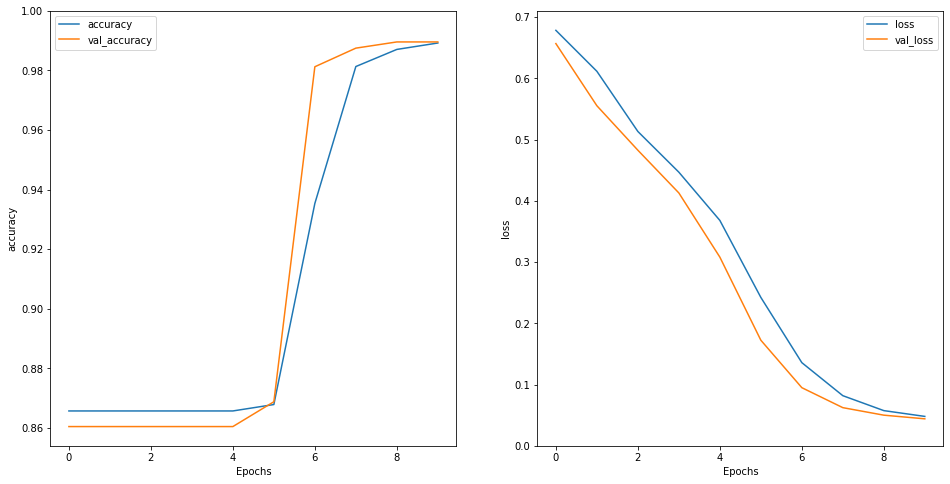

In [20]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [21]:
h = history.history
print(h['loss'])
print(h['val_loss'])
print(h['accuracy'])
print(h['val_accuracy'])

[0.6782429814338684, 0.6113942265510559, 0.5131464004516602, 0.4466909170150757, 0.3679655194282532, 0.242261603474617, 0.13573822379112244, 0.08182205259799957, 0.057438742369413376, 0.047989822924137115]
[0.6566107273101807, 0.5551645159721375, 0.4825538694858551, 0.4127844274044037, 0.3080359697341919, 0.1723845899105072, 0.09488749504089355, 0.062275536358356476, 0.05000969022512436, 0.04403859004378319]
[0.8656609058380127, 0.8656609058380127, 0.8656609058380127, 0.8656609058380127, 0.8656609058380127, 0.8678160905838013, 0.9353448152542114, 0.9813218116760254, 0.9870689511299133, 0.9892241358757019]
[0.8604166507720947, 0.8604166507720947, 0.8604166507720947, 0.8604166507720947, 0.8604166507720947, 0.8687499761581421, 0.981249988079071, 0.987500011920929, 0.9895833134651184, 0.9895833134651184]


In [22]:
# function to predict messages based on model
# (should return list containing prediction and label, ex. [0.008318834938108921, 'ham'])
def predict_message(pred_text):
    ps = model.predict([pred_text])
    print(ps)
    p = ps[0][0]
    return [p, "ham" if p <0.5 else "spam"]

pred_text = "how are you doing today?"

prediction = predict_message(pred_text)
print(prediction)

[[-4.9608545]]
[-4.9608545, 'ham']


## 5.3 Testing

In [26]:
# Run this cell to test your function and model. Do not modify contents.
def test_predictions():
  test_messages = ["how are you doing today",
                   "sale today! to stop texts call 98912460 4",
                   "i dont want to go. can we try it a different day? available sat",
                   "our new mobile video service is live. just install on your phone to start watching.",
                   "you have won £1000 cash! call to claim your prize.",
                   "i'll bring it tomorrow. don't forget the milk.",
                   "wow, is your arm alright. that happened to me one time too"
                  ]

  test_answers = ["ham", "spam", "ham", "spam", "spam", "ham", "ham"]
  passed = False

  for msg, ans in zip(test_messages, test_answers):
    prediction = predict_message(msg)
    if prediction[1] != ans:
      passed = True

  if passed:
    print("You passed the challenge. Great job!")
  else:
    print("You haven't passed yet. Keep trying.")

test_predictions()

[[-4.9608545]]
[[0.4206466]]
[[-9.183814]]
[[1.4621414]]
[[2.6312542]]
[[-8.52661]]
[[-8.632161]]
You passed the challenge. Great job!
